In [1]:
import pandas as pd
import numpy as np
import warnings
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint
from scipy.stats import pearsonr

feature_files = find_files('/mnt/primus/xuemeng_tmp_harbour/tillage_index/data_and_feature_set','*feature*')
feature_files = [str(i) for i in feature_files]
feature_files = [i for i in feature_files if 'checkpoint' not in i]

train = pd.read_csv('/mnt/primus/xuemeng_tmp_harbour/tillage_index/data_and_feature_set/003.1_data.train_soc.txt', low_memory=False)
test = pd.read_csv('/mnt/primus/xuemeng_tmp_harbour/tillage_index/data_and_feature_set/003.2_data.test_soc.txt', low_memory=False)

def calc_ccc(y_true, y_pred):
    pearson_corr = pearsonr(y_true, y_pred)[0]
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    ccc = 2 * pearson_corr * np.sqrt(var_true) * np.sqrt(var_pred) / (var_true + var_pred + (mean_true - mean_pred) ** 2)
    return ccc

tgt = 'oc_log1p'
train['oc_log1p'] = np.log1p(train['oc'])
test['oc_log1p'] = np.log1p(test['oc'])

In [3]:
## create feature sets
from itertools import combinations

# Function to load features from files
def load_features(files):
    feature_sets = {}
    for file in files:
        name = file.split('/')[-1].split('_')[-1].split('.')[-2]
        with open(file, 'r') as file_r:
            lines = file_r.readlines()
        lines = [s.strip() for s in lines]
        feature_sets[name] = lines
    return feature_sets

# Load all feature sets
feature_sets = load_features(feature_files)

themes = ['band', 'crop', 'soil', 'vegetation', 'water']
tiers = ['tier1', 'tier2', 'tier3', 'tier4']

### feature comparison

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

## loop through all the tier combinations
keys = tiers
tier_combi = {}
for inum in range(1,len(keys)+1):
    for comb in combinations(tiers, inum):
        name = ''
        feat = []
        for ikey in comb:
            name = name+'+'+ikey
            feat.extend(feature_sets[ikey])
        name = name[1::]
        tier_combi[name] = feat
    

results = pd.DataFrame(columns=['feature combination', 'CCC', 'RMSE', 'R2'])

params = {'max_depth': 20, 
          'max_features': 'sqrt', 
          'min_samples_leaf': 2, 
          'min_samples_split': 5, 
          'n_estimators': 800}

# Iterate over feature combinations
for ikey in tier_combi.keys():
    covs = tier_combi[ikey]
    # Train Random Forest Regressor
    rf = RandomForestRegressor(**params, random_state=42, n_jobs=50)
    rf.fit(train[covs], train[tgt])
    
    # Make predictions
    y_pred = rf.predict(test[covs])
    
    # Calculate metrics
    y_test = test[tgt]
    ccc = calc_ccc(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.loc[len(results)] = [ikey, ccc, rmse, r2]

results.to_csv('/mnt/primus/xuemeng_tmp_harbour/tillage_index/data_and_feature_set/005.1_metrics_soc.tier.csv', index=False)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

## loop through all the theme combinations
keys = themes
theme_combi = {}
for inum in range(1,len(keys)+1):
    for comb in combinations(themes, inum):
        name = ''
        feat = []
        for ikey in comb:
            name = name+'+'+ikey
            feat.extend(feature_sets[ikey])
        name = name[1::]
        theme_combi[name] = feat
    

results = pd.DataFrame(columns=['feature combination', 'CCC', 'RMSE', 'R2'])

params = {'max_depth': 20, 
          'max_features': 'sqrt', 
          'min_samples_leaf': 2, 
          'min_samples_split': 5, 
          'n_estimators': 800}

# Iterate over feature combinations
for ikey in theme_combi.keys():
    covs = theme_combi[ikey]
    # Train Random Forest Regressor
    rf = RandomForestRegressor(**params, random_state=42, n_jobs=50)
    rf.fit(train[covs], train[tgt])
    
    # Make predictions
    y_pred = rf.predict(test[covs])
    
    # Calculate metrics
    ccc = calc_ccc(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.loc[len(results)] = [ikey, ccc, rmse, r2]

results.to_csv('/mnt/primus/xuemeng_tmp_harbour/tillage_index/data_and_feature_set/005.2_metrics_soc.theme.csv', index=False)

### plot feature importance

In [18]:
from sklearn.ensemble import RandomForestRegressor
df = pd.read_csv('/mnt/primus/xuemeng_tmp_harbour/tillage_index/data_and_feature_set/003_data_soc.txt', low_memory=False)
df[tgt] = np.log1p(df['oc'])
params = {'max_depth': 20, 
          'max_features': 'sqrt', 
          'min_samples_leaf': 2, 
          'min_samples_split': 5, 
          'n_estimators': 800}
covs = feature_sets['all']

model = RandomForestRegressor(**params, random_state=42, n_jobs=50)
model.fit(df[covs],df[tgt])

# from sklearn.feature_selection import RFECV
# from sklearn.model_selection import StratifiedKFold
# selector = RFECV(model, step=1, cv=5, scoring='neg_mean_squared_error')
# selector.fit(train[covs], train[tgt])

# model.fit(train[covs].iloc[:, selector.support_], train[tgt])

# y_pred = model.predict(test[covs].iloc[:, selector.support_])
# y_pred = model.predict(test[covs].iloc[:, selector.support_])
# y_test = test[tgt]
# ccc = calc_ccc(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)
# print(ccc, rmse, r2)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=800, n_jobs=50,
                      random_state=42)

In [19]:
# rename covariates to be simpler
names = []
for iii in df[covs]: #.iloc[:, selector.support_]
    if 'savi' in iii:
        kkk = iii.split('_')[0] + '.' + iii.split('_')[2] + '_' + iii.split('_')[4] + '_' + iii.split('_')[5]
    else:
        kkk = iii.split('_')[0] + '.' + iii.split('_')[2] + '_' + iii.split('_')[5] + '_' + iii.split('_')[6]
    kkk = kkk.replace('.m_', '_')
    kkk = kkk.replace('.30m_', '_')
    kkk = kkk.replace('.sum_', '_')
    if 'theilslopes' in iii and '.slopes' not in iii:
        kkk = kkk.replace('_20000101_20221231','.slopes_20000101_20221231')
    kkk = kkk.replace('slopes', 'trend')  
    names.append(kkk)
    
    
feature_importance = dict(zip(names,list(model.feature_importances_)))

sorted_importances = sorted(zip(names, model.feature_importances_), key=lambda x: x[1], reverse=True)
sorted_feature_importance = {feature: importance for feature, importance in sorted_importances}
sorted_feature_importance

{'ndvi.p25_20000101_20221231': 0.042149776174638776,
 'ndti.p25_{year}0101_{year}1231': 0.0388561015814427,
 'ndvi.p50_20000101_20221231': 0.03469576892307351,
 'ndti.p50_{year}0101_{year}1231': 0.03333905968628141,
 'ndti.min_{year}0101_{year}1231': 0.03129521481754258,
 'ndwi.gao.p25_20000101_20221231': 0.02248415891411248,
 'ndti_{year}0901_{year}1031': 0.021459358216020234,
 'red.p50_{year}0101_{year}1231': 0.019289703451718425,
 'ndti.p75_{year}0101_{year}1231': 0.01885415906046021,
 'blue.p50_{year}0101_{year}1231': 0.017716228763439652,
 'red.p25_{year}0101_{year}1231': 0.016373512765925802,
 'swir2.p75_{year}0101_{year}1231': 0.015200544122535199,
 'ndti_{year}0701_{year}0831': 0.012679000115023627,
 'blue.p25_{year}0101_{year}1231': 0.01232067232152198,
 'thermal_{year}0101_{year}0228': 0.011968437641645277,
 'green.p50_{year}0101_{year}1231': 0.011843888187247891,
 'ndvi.p50_{year}0101_{year}1231': 0.01179494497961434,
 'ndti_{year}1101_{year}1231': 0.010930556017399317,
 'nd

In [11]:
with open('/mnt/primus/xuemeng_tmp_harbour/tillage_index/data_and_feature_set/006.1_feature.importace_soc.rfecv.txt', 'w') as file:
    for feature, importance in sorted_feature_importance.items():
        file.write(f"{feature}: {importance}\n")


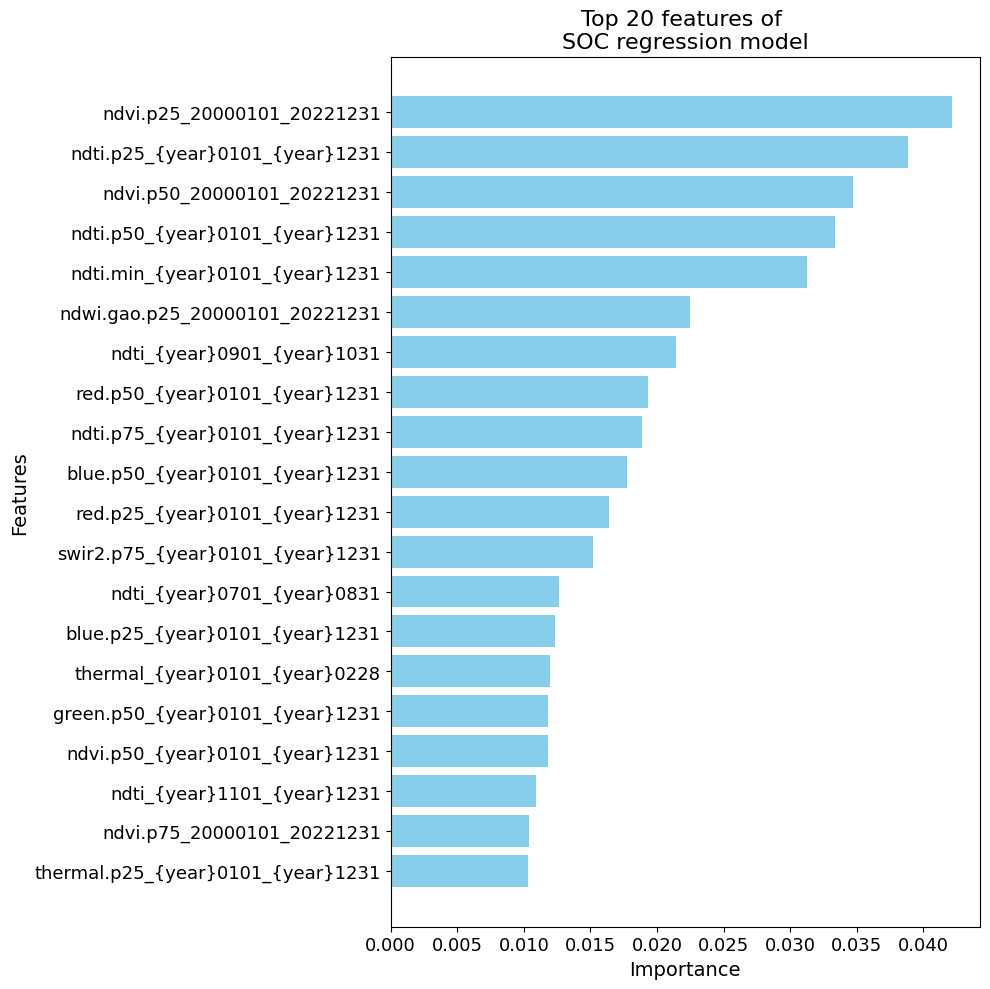

In [20]:
import matplotlib.pyplot as plt

sorted_features, sorted_importances = zip(*sorted_feature_importance.items())

plt.figure(figsize=(10, 10))
plt.barh(sorted_features[0:20], sorted_importances[0:20], color='skyblue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 20 features of \nSOC regression model', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Invert y-axis for better readability
plt.gca().invert_yaxis()

plt.tight_layout()
# Save the figure ensuring all content is included
plt.savefig('15_feature.importances_soc.pdf', format='pdf', dpi=300) #, format='svg', , bbox_inches='tight')

# Display the plot
plt.show()

/tmp/ipykernel_63070/3906813110.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


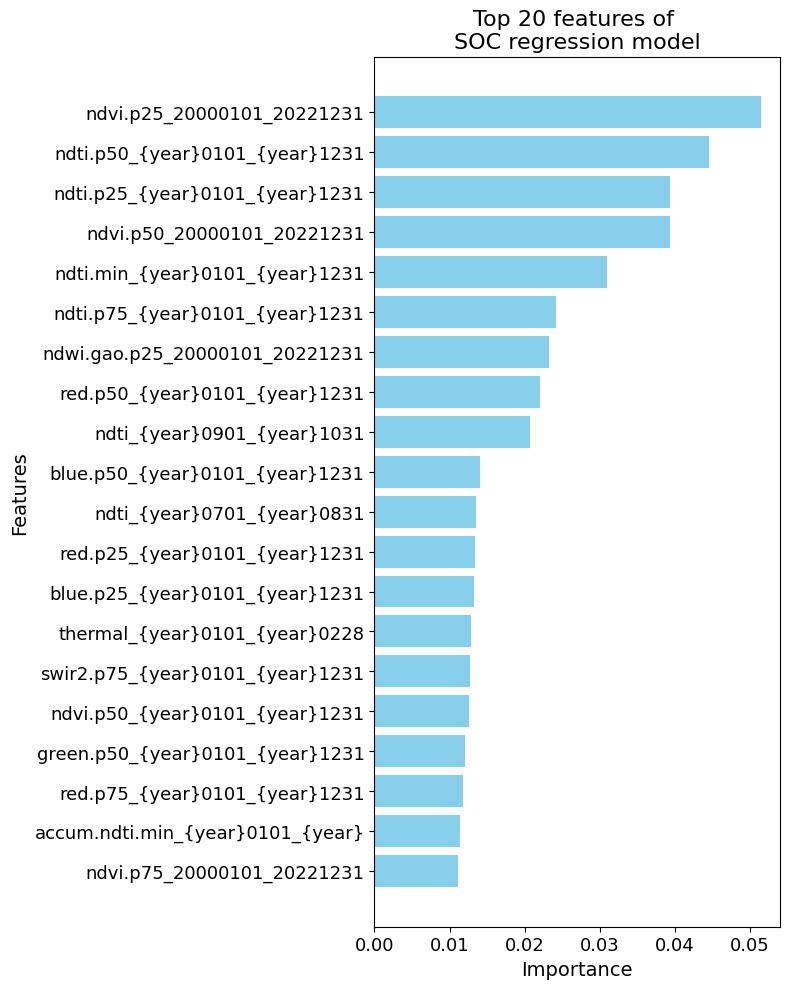

In [110]:
import matplotlib.pyplot as plt

sorted_features, sorted_importances = zip(*sorted_feature_importance.items())

plt.figure(figsize=(8, 10))
plt.barh(sorted_features[0:20], sorted_importances[0:20], color='skyblue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 20 features of \nSOC regression model', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Invert y-axis for better readability
plt.gca().invert_yaxis()

plt.tight_layout()
# Save the figure ensuring all content is included
plt.savefig('15_feature.importances_soc.pdf', format='pdf', dpi=300) #, format='svg', , bbox_inches='tight')

# Display the plot
plt.show()

### plot metrics for different feature combinations